In [1]:
import pandas as pd 
import omnipath as op
import numpy as np
import networkx as nx 
import torch_geometric as pyg
import torch
from matplotlib import pyplot as plt 
import shutil
import h5py
import os 
import seaborn as sbn 
import numpy as np
import math

import sys 
sys.path.append('../')
from src.proc import utils
from src.proc.utils import filter_to_common_cellspace, impute_missing_gene_ids
from src.proc.load_methyl import load_methyl
from src.proc.load_expr import load_expr
from src.proc.load_cnv import load_cnv
from src.proc.load_mut import load_mut
from src.proc.load_prism import load_prism

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/grcp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Omnipath network construction

In [2]:
__DATA__ = '../../data/'
__OUT_DIR__ = '../processed_data/'

__ONLY_INCLUDE_EXEMPLAR_SIGNATURES__ = False

# subjective trend: "landmark" produces better r2 values 
__LINCS_FEATURE_SPACE__ = ['landmark'] #,'best inferred']

# drug targets 
__INCLUDE_STITCH_TARGETS__ = False
__INCLUDE_TARGETOME_TARGETS__ = True
__DRUGINFO_MIN_SCORE__ = 950 # 500- 1000
__MIN_PROP_DOWNSTREAM_LINCS_PER_DRUG__ = 0.4

# time points to include 
__INCLUDE_TIME__ = [24.]

# drugspace + cellspace 
__MIN_NUM_OBS_PER_DRUG__ = 3
__MIN_OBS_PER_CELL_LINE__ = 10

# train/test splits 
__TEST_PROP__ = 0.2
__VAL_PROP__ = 0.

# Signal Transduction                       - R-HSA-162582      (2584)
# Signaling by Receptor Tyrosine Kinases    - R-HSA-9006934     (519)
# MAPK family signaling cascades            - R-HSA-5683057     (327)
# Disease                                   - R-HSA-1643685     (1859)
# Metabolism                                - R-HSA-1430728     (2114)
# Gene expression (Transcription)           - R-HSA-74160       (1517)
# Signaling by SCF-KIT                      - R-HSA-1433559     (16)            # https://reactome.org/PathwayBrowser/#/R-HSA-1433557&SEL=R-HSA-1433559&PATH=R-HSA-162582,R-HSA-9006934
# Signaling by EGFR                         - R-HSA-177929      (52)            # https://reactome.org/PathwayBrowser/#/R-HSA-177929&PATH=R-HSA-162582,R-HSA-9006934
__pathways__ = ['R-HSA-5683057']


In [3]:
# omnipath.interactions.Dorothea        :: protein (TF) -> gene 
# omnipath.interactions.OmniPath        :: protein -> protein           :: literature curated and are either activity flow, enzyme-PTM or undirected interaction resources. We also added network databases with high-throughput data. Then we added further directions and effect signs from resources without literature references.
# omnipath.interactions.PathwayExtra    :: protein -> protein           :: activity flow resources without literature references. However, they are manually curated and many have effect signs.
# omnipath.interactions.TFmiRNA         :: protein (TF) -> gene         :: Transcriptional regulation of miRNA (“tf_mirna”) from 2 literature curated resources.
# omnipath.interactions.miRNA           :: RNA -> RNA                   :: contains miRNA-mRNA interactions. 

In [4]:
dorothea = op.interactions.Dorothea().get()
omnipath = op.interactions.OmniPath().get()
pathways_extra = op.interactions.PathwayExtra().get()
tf_mirna = op.interactions.TFmiRNA().get()
mirna = op.interactions.miRNA().get()

num_edges = sum([x.shape[0] for x in [dorothea, omnipath, pathways_extra, tf_mirna, mirna]])
print('total # of edges:', num_edges)

total # of edges: 172123


# Choose protein subset 

This is how we filter the graph subset. 

The protein space will be limited to a subset of this. All interactions out side of this subset will be removed. 

The other `-spaces` will be constructed as normal (see ppt). 

In [5]:
# WARNING: make sure to reload data from above if re-running this cell

if __pathways__ is not None: 

    # get pathway uniprot symbols 
    uni2rea = pd.read_csv(f'{__DATA__}/UniProt2Reactome_All_Levels.txt', sep='\t', header=None, low_memory=False, dtype=str)
    uni2rea.columns = ['uniprot', 'pathway', 'source', 'description', 'acc', 'species']
    uni2rea = uni2rea[lambda x: ~x.pathway.isna()]
    uni2rea.pathway = [str(p) for p in uni2rea.pathway]
    uni2rea = uni2rea[lambda x: (x.pathway.isin(__pathways__)) & (x.species == 'Homo sapiens')]

    include_uniprot = uni2rea.uniprot.unique()
    print('pathway size:', len(include_uniprot))

    # filter `dorothea` proteins (source)
    dorothea = dorothea[lambda x: x.source.isin(include_uniprot)]

    # filter `omnipath` proiteins (source, target)
    omnipath = omnipath[lambda x: x.source.isin(include_uniprot) & x.target.isin(include_uniprot)]

    # filter `pathways_extra` (source, target)
    pathways_extra = pathways_extra[lambda x: x.source.isin(include_uniprot) & x.target.isin(include_uniprot)]

    # filter `tf_mirna` (source)
    tf_mirna = tf_mirna[lambda x: x.source.isin(include_uniprot)]

pathway size: 338


# Gene Mapping 

In [6]:
uni2id = pd.read_csv('../extdata/omnipath_uniprot2geneid.tsv', sep='\t').rename({'From':'uniprot', 'To':'gene_id'}, axis=1)
uni2symb = pd.read_csv('../extdata/omnipath_uniprot2genesymb.tsv', sep='\t').rename({'From':'uniprot', 'To':'gene_symbol'}, axis=1)
gene_map = uni2id.merge(uni2symb, on='uniprot', how='outer')
gene_map.head()

,uniprot,gene_id,gene_symbol
0,Q8NEM1,340252.0,ZNF680
1,Q9Y496,11127.0,KIF3A
2,Q6ZWJ1,252983.0,STXBP4
3,Q8TAM1,79738.0,BBS10
4,Q8NEX6,259239.0,WFDC11


# LINCS gene overhead 

(for rna space construction critiera)

In [7]:
geneinfo = pd.read_csv(f'{__DATA__}/geneinfo_beta.txt', sep='\t')[lambda x: x.feature_space.isin(__LINCS_FEATURE_SPACE__)].merge(gene_map, on=['gene_id'], how='left')

# lincs genes with uniport ids 
__LINCS_GENES_UNIPROT__ = geneinfo.uniprot.dropna().unique()
len(__LINCS_GENES_UNIPROT__)

960

In [8]:
lincs_uni2id = {row.uniprot: row.gene_id for i,row in geneinfo[['uniprot', 'gene_id']].dropna().iterrows()}
lincs_id2uni = {row.gene_id:row.uniprot for i,row in geneinfo[['uniprot', 'gene_id']].dropna().iterrows()}

# Load and filter LINCS obs 

In [9]:
siginfo = pd.read_csv(f'{__DATA__}/siginfo_beta.txt', sep='\t', low_memory=False)

siginfo = siginfo[lambda x: (x.pert_type.isin(['trt_cp'])) 
                     & (x.qc_pass == 1.) 
                     & (np.isfinite(x.pert_time.values))
                     & (x.pert_time.values > 0)                 # some values are -666 
                     & (x.pert_id != None)
                     & (x.cell_iname != None)
                     & (np.isfinite(x.pert_dose.values))
                     & (x.pert_time.isin(__INCLUDE_TIME__))]

if __ONLY_INCLUDE_EXEMPLAR_SIGNATURES__: 
    siginfo = siginfo[lambda x: x.is_exemplar_sig == 1]

# Create gene/protein/rna spaces

In [10]:
# all TF dataset `target`s. 
# all rna nodes included must have at least one regulatory edge from a protein in our protein space or from a MIRNA 
#                       # TF targets                    TF targets (miRNA)               
rna_space = np.unique(dorothea.target.values.tolist() + tf_mirna.target.values.tolist()).tolist()
ntfrna = len(rna_space)
print('# TF regulated RNAs:', ntfrna)

# add RNAs that are in the miRNA regulatory network 
# e.g., must have miRNA edge from rna_space -> new_rna
for i in range(3): 
    new_rnas = list(set(mirna[lambda x: (x.source.isin(rna_space))].target.tolist()) - set(rna_space))
    rna_space += new_rnas 
    print(i, '# added rnas', len(new_rnas))

rna_space = np.unique(rna_space)
print('# miRNA regulated RNAs:', len(rna_space) - ntfrna)
_mirnas = mirna[lambda x: (x.source.isin(rna_space))].source.unique()
print('# of miRNA regulators:', len(_mirnas))

# TF `source` and PPI `source` + `target`
protein_space   = np.unique(dorothea.source.values.tolist() 
                          + omnipath.source.values.tolist() + omnipath.target.values.tolist() 
                          + pathways_extra.source.values.tolist() + pathways_extra.target.values.tolist()
                          + tf_mirna.source.values.tolist())

# TF regulated RNAs: 772
0 # added rnas 2052
1 # added rnas 0
2 # added rnas 0
# miRNA regulated RNAs: 2052
# of miRNA regulators: 190


In [11]:
_tfs = np.unique(tf_mirna.source.values.tolist() + dorothea.source.values.tolist())
print('# of TFs:', len(_tfs))

print('Final RNA-space size:', len(rna_space))
print('Final PROTEIN-space size:', len(protein_space))

rna_in_prot = set(rna_space.tolist()).intersection(set(protein_space.tolist()))

print()
print('overlap between rna-prot', len(rna_in_prot))

# NOTE: not all proteins have gene/rna nodes - but that's okay bc it means we have no transcriptional regulation information 
print()
prots_missing_rna = set(protein_space.tolist()) - set(rna_space.tolist())
print('# proteins without rna/gene nodes:', len(prots_missing_rna))

# NOTE: not all rna molecules will have a protein product 
print()
rna_without_prot = set(rna_space.tolist()) - set(protein_space.tolist())
print('# rna molecules without protein products:', len(rna_without_prot))

# of TFs: 15
Final RNA-space size: 2824
Final PROTEIN-space size: 277

overlap between rna-prot 114

# proteins without rna/gene nodes: 163

# rna molecules without protein products: 2710


# Create LINCS-space

Create the initial `lincs_space` (e.g., LINCS RNA nodes to include in our biological network). 

In [12]:
lincs_in_rna_space = set(rna_space.tolist()).intersection(set(__LINCS_GENES_UNIPROT__.tolist()))

print('# lincs (best inferred + landmark) genes in rna-space:', len(lincs_in_rna_space))
print(f'proportion of all rna nodes with LINCS coverage (feature-space: {__LINCS_FEATURE_SPACE__}):', len(lincs_in_rna_space)/len(rna_space))

# lincs (best inferred + landmark) genes in rna-space: 330
proportion of all rna nodes with LINCS coverage (feature-space: ['landmark']): 0.11685552407932011


In [13]:
# are any of the genes non-uniquely mapped? 
# NOTE: these mappings will be dropped and only one unique mapping used. 
lincs2uniprot = geneinfo[lambda x: x.uniprot.isin(lincs_in_rna_space)].set_index('gene_id')['uniprot'].drop_duplicates().to_dict()

lincs_space_gene_ids = np.array(list(lincs2uniprot.keys()))

lincs_space = np.sort(list(lincs2uniprot.values()))
len(lincs_space)

328

# Get Drug-Targets 

In [14]:
druginfo = pd.read_csv(f'{__DATA__}/compoundinfo_beta.txt', sep='\t')

clue_drug_target_symbols = druginfo.target.unique()

gene2uni = gene_map[['uniprot', 'gene_symbol']]

druginfo = druginfo.merge(gene2uni, left_on='target', right_on='gene_symbol', how='inner') 

druginfo = druginfo[['pert_id', 'uniprot', 'moa']].rename({'uniprot':'target'}, axis=1)

druginfo = druginfo.assign(combined_score=1000, source='clue')

if __INCLUDE_STITCH_TARGETS__: 
    stitch = pd.read_csv('../extdata/processed_stitch_targets.csv')
    stitch = stitch.assign(source='stitch', moa='')

    druginfo = pd.concat((druginfo, stitch), axis=0)

if __INCLUDE_TARGETOME_TARGETS__: 
    targ = pd.read_csv('../extdata/targetome_with_broad_ids.csv')
    targ = targ.rename({'Target_UniProt':'target'}, axis=1)
    targ = targ.assign(combined_score = 1000, source='targetome', moa='')
    targ = targ[['pert_id','target','combined_score','moa','source']]

    druginfo = pd.concat((druginfo, targ), axis=0)

druginfo = druginfo.groupby(['pert_id', 'target']).agg({'combined_score' : np.mean, "moa" : lambda x: ','.join(x), 'source':lambda x: '+'.join(x)}).reset_index()

# filter to protein-space
druginfo = druginfo[lambda x: x.target.isin(protein_space)]

# apply score filter 
druginfo = druginfo[lambda x: x.combined_score >= __DRUGINFO_MIN_SCORE__]

druginfo.head()

,pert_id,target,combined_score,moa,source
39,BRD-A02508087,Q05586,1000.0,Glutamate receptor agonist,clue
41,BRD-A02508087,Q13224,1000.0,Glutamate receptor agonist,clue
81,BRD-A04706586,P17612,1000.0,"CAMP stimulant,Adenosine receptor agonist",clue+clue
130,BRD-A08840375,P27361,1000.0,MAP kinase phosphatase inhibitor,clue
175,BRD-A11007541,P28562,1000.0,Protein phosphatase inhibitor,clue


In [15]:
druginfo.groupby('source').count()[['pert_id']].sort_values('pert_id', ascending=False).head(5)

,pert_id
source,
clue,215
targetome,154
targetome+targetome,101
clue+clue,77
clue+clue+clue,53


# Get Drugspace

In [16]:
drug_space = siginfo[lambda x: x.pert_type == 'trt_cp'].pert_id.unique()
len(drug_space)

20384

In [17]:
# drugs we have targets for (in protein_space)
drug_space_with_targets = druginfo.pert_id.unique()
len(drug_space_with_targets)

287

In [18]:
num_obs_with_targets = siginfo[lambda x: x.pert_id.isin(drug_space_with_targets)].shape[0]

print('# obs from drugs with targets:', num_obs_with_targets)

drug_space = drug_space_with_targets

# obs from drugs with targets: 50619


In [19]:
# filter low cnt drugs 
sigcnts = siginfo.groupby('pert_id').count()['sig_id'].reset_index().rename({'sig_id':'cnts'}, axis=1)

# filter perts with fewer XX number of observations 
sigcnts = sigcnts[lambda x: x.cnts >= __MIN_NUM_OBS_PER_DRUG__]

# remove any drugs that don't have observations in LINCS
print('drug space before', len(drug_space))
drug_space = np.sort(list(set(sigcnts.pert_id.values.tolist()).intersection(drug_space)))
print('drug space after', len(drug_space))

drug space before 287
drug space after 281


In [20]:
druginfo2 = druginfo.assign(source                  = lambda x: x.pert_id,
                            is_stimulation          = False, 
                            is_inhibition           = False,
                            is_directed             = True,
                            curation_effort         = 0, 
                            consensus_stimulation   = False, 
                            consensus_inhibition    = False, 
                            n_references            = 0, 
                            n_sources               = 0, 
                            n_primary_sources       = 0,
                            edge_type               = 'drug-target') 

print('before', druginfo2.shape)
druginfo2 = druginfo2[lambda x: x.target.isin(protein_space)]
druginfo2 = druginfo2[lambda x: x.pert_id.isin(drug_space)]
print('after', druginfo2.shape)

drug_space = np.sort(druginfo2.pert_id.unique())
print('final drug space size:', len(drug_space))

druginfo2.head()

before (753, 15)
after (745, 15)
final drug space size: 281


,pert_id,target,combined_score,moa,source,is_stimulation,is_inhibition,is_directed,curation_effort,consensus_stimulation,consensus_inhibition,n_references,n_sources,n_primary_sources,edge_type
39,BRD-A02508087,Q05586,1000.0,Glutamate receptor agonist,BRD-A02508087,False,False,True,0,False,False,0,0,0,drug-target
41,BRD-A02508087,Q13224,1000.0,Glutamate receptor agonist,BRD-A02508087,False,False,True,0,False,False,0,0,0,drug-target
81,BRD-A04706586,P17612,1000.0,"CAMP stimulant,Adenosine receptor agonist",BRD-A04706586,False,False,True,0,False,False,0,0,0,drug-target
130,BRD-A08840375,P27361,1000.0,MAP kinase phosphatase inhibitor,BRD-A08840375,False,False,True,0,False,False,0,0,0,drug-target
175,BRD-A11007541,P28562,1000.0,Protein phosphatase inhibitor,BRD-A11007541,False,False,True,0,False,False,0,0,0,drug-target


# Filter Drug-space by proprotion of downstream LINCS nodes

Just because a drug-target is in our `protein-space` does not mean that it has downstream LINCS nodes. 

In [21]:
def downstream_nodes(G, node, N, visited=None):
    # If visited is None, initialize it as an empty set
    if visited is None:
        visited = set()

    # Add the current node to the visited set
    visited.add(node)

    downstream = []
    if N > 0:
        for n in G.successors(node):
            if n not in visited:
                # Add this node and all its downstream nodes to the list
                downstream.append(n)
                downstream.extend(downstream_nodes(G, n, N-1, visited))

    return downstream

In [22]:
# create a homogenous graph with one edge type to use for infering "upstream" genes 

all_edges = pd.concat([dorothea, omnipath, pathways_extra, tf_mirna, mirna], axis=0)

G = nx.DiGraph()
for i,edge in all_edges.iterrows(): 
    G.add_edge(edge.source, edge.target)

In [23]:
_drug_res = {'pert_id':[], 'num_downstream_lincs':[]}
for i, pert_id in enumerate(drug_space):
    print(f'progress {i}/{len(drug_space)}', end='\r')
    targs = druginfo2[lambda x: x.pert_id == pert_id]
    downstream = [] 
    for t in targs.target.values:
        downstream += downstream_nodes(G, t, N=10)
    downstream = np.unique(downstream)
    lincs_downstream = set(downstream).intersection(set(lincs_space))

    _drug_res['pert_id'].append(pert_id)
    _drug_res['num_downstream_lincs'].append(len(lincs_downstream))

_drug_res = pd.DataFrame(_drug_res)
_drug_res = _drug_res.assign(p_downstream_lincs = lambda x: x.num_downstream_lincs / len(lincs_space))
_drug_res.head()


,pert_id,num_downstream_lincs,p_downstream_lincs
0,BRD-A02508087,0,0.000000
1,BRD-A04706586,22,0.067073
2,BRD-A08840375,24,0.073171
3,BRD-A11007541,146,0.445122
4,BRD-A11678676,167,0.509146


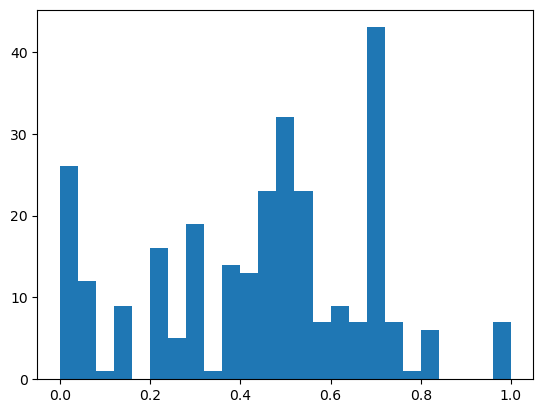

In [24]:
plt.figure()
plt.hist(_drug_res.p_downstream_lincs, bins=25)
plt.show()

In [25]:
drug_space = np.sort(_drug_res[lambda x: x.p_downstream_lincs >= __MIN_PROP_DOWNSTREAM_LINCS_PER_DRUG__].pert_id.values)
druginfo2 = druginfo2[lambda x: x.pert_id.isin(drug_space)]
print('drugspace size:', len(drug_space))

drugspace size: 178


In [26]:
# get valid observation sig_id 
drug_sig_ids = siginfo[lambda x: x.pert_id.isin(drug_space)].sig_id.unique()

print('# of drug obs:', len(drug_sig_ids))

# of drug obs: 38291


In [27]:
# double check all drugs have at least one target
assert druginfo2.pert_id.unique().shape[0] == len(drug_space), 'drugspace does not match available target infomation in druginfo2'

# Make the pytorch geometric graph

In [28]:
# omnipath.interactions.Dorothea        :: protein (TF) -> gene 
# omnipath.interactions.OmniPath        :: protein -> protein           :: literature curated and are either activity flow, enzyme-PTM or undirected interaction resources. We also added network databases with high-throughput data. Then we added further directions and effect signs from resources without literature references.
# omnipath.interactions.PathwayExtra    :: protein -> protein           :: activity flow resources without literature references. However, they are manually curated and many have effect signs.
# omnipath.interactions.TFmiRNA         :: protein (TF) -> gene         :: Transcriptional regulation of miRNA (“tf_mirna”) from 2 literature curated resources.
# omnipath.interactions.miRNA           :: RNA -> RNA                   :: contains miRNA-mRNA interactions. 

doro = dorothea[lambda x: x.source.isin(protein_space) & x.target.isin(rna_space)].assign(source = lambda x: ['PROTEIN__' + y for y in x.source],
                    target = lambda x: ['RNA__' + y for y in x.target], 
                    edge_type = 'dorothea',
                    input_edge = False, 
                    output_edge = False)[['source', 'target', 'edge_type', 'input_edge', 'output_edge']]

omni = omnipath[lambda x: x.source.isin(protein_space) & x.target.isin(protein_space)].assign(source = lambda x: ['PROTEIN__' + y for y in x.source],
                    target = lambda x: ['PROTEIN__' + y for y in x.target], 
                    edge_type = 'omnipath',
                    input_edge = False, 
                    output_edge = False)[['source', 'target', 'edge_type', 'input_edge', 'output_edge']]

path = pathways_extra[lambda x: x.source.isin(protein_space) & x.target.isin(protein_space)].assign(source = lambda x: ['PROTEIN__' + y for y in x.source],
                    target = lambda x: ['PROTEIN__' + y for y in x.target], 
                    edge_type = 'pathways_extra',
                    input_edge = False, 
                    output_edge = False)[['source', 'target', 'edge_type', 'input_edge', 'output_edge']]     

tfmirna = tf_mirna[lambda x: x.source.isin(protein_space) & x.target.isin(rna_space)].assign(source = lambda x: ['PROTEIN__' + y for y in x.source],
                    target = lambda x: ['RNA__' + y for y in x.target], 
                    edge_type = 'tf_mirna',
                    input_edge = False, 
                    output_edge = False)[['source', 'target', 'edge_type', 'input_edge', 'output_edge']]

mirna_ = mirna[lambda x: x.source.isin(rna_space) & x.target.isin(rna_space)].assign(source = lambda x: ['RNA__' + y for y in x.source],
                    target = lambda x: ['RNA__' + y for y in x.target], 
                    edge_type = 'mirna',
                    input_edge = False, 
                    output_edge = False)[['source', 'target', 'edge_type', 'input_edge', 'output_edge']]  

drug = druginfo2[lambda x: x.source.isin(drug_space) & x.target.isin(protein_space)].assign(source = lambda x: ['DRUG__' + y for y in x.source],
                    target = lambda x: ['PROTEIN__' + y for y in x.target], 
                    edge_type = 'drug_input',
                    input_edge = True, 
                    output_edge = False)[['source', 'target', 'edge_type', 'input_edge', 'output_edge']]          

lincs = pd.DataFrame({'source':['RNA__' + x for x in lincs_space], 
                      'target':['LINCS__' + x for x in lincs_space], 
                      'edge_type':'lincs', 
                      'input_edge' : False, 
                      'output_edge' : True})

RNA_PROT_OVERLAP = list(set(rna_space).intersection(set(protein_space)))
trans = pd.DataFrame({'source': ['RNA__' + x for x in RNA_PROT_OVERLAP],
                      'target': ['PROTEIN__' + x for x in RNA_PROT_OVERLAP],
                      'edge_type':'translation', 
                      'input_edge' : False, 
                      'output_edge' : False})

# expr omics input values
expr_ = pd.DataFrame({'source': ['EXPR__' + x for x in rna_space] + ['EXPR__' + x for x in protein_space],
                      'target': ['RNA__' + x for x in rna_space] + ['PROTEIN__' + x for x in protein_space],
                      'edge_type':'expr_input', 
                      'input_edge' : True, 
                      'output_edge' : False})

edgelist = pd.concat([doro, omni, path, tfmirna, mirna_, drug, lincs, trans, expr_], axis=0)

node_space = np.sort(np.unique(edgelist.source.values.tolist() + edgelist.target.values.tolist()))
node2idx = {n:i for i,n in enumerate(node_space)}

print('Total # of nodes:', len(node_space))
print('Total # of edges:', len(edgelist))

Total # of nodes: 6594
Total # of edges: 13777


In [29]:
# create nx DiGraph and remove any nodes that don't have a LINCS gene downstream. 
LINCS_nodes = [x for x in node_space if 'LINCS__' in x]
print('# lincs nodes', len(LINCS_nodes))

G = nx.DiGraph()
for i,row in edgelist.iterrows(): 
    G.add_edge(row.source, row.target)


nodes_to_remove = [] 

for i,node in enumerate(G.nodes()): 
    print('progress', i, end='\r')
    has_lincs_downstream = False

    if node in LINCS_nodes: 
        has_lincs_downstream = True 
        continue 
    
    for lincs in LINCS_nodes: 
        if nx.has_path(G, node, lincs): 
            has_lincs_downstream = True 
            break 

    if not has_lincs_downstream: 
        nodes_to_remove.append(node)

print('# of nodes to remove (no downstream LINCS nodes)', len(nodes_to_remove))

edgelist = edgelist[lambda x: (~x.source.isin(nodes_to_remove)) & (~x.target.isin(nodes_to_remove))]

node_space = np.sort(np.unique(edgelist.source.values.tolist() + edgelist.target.values.tolist()))
node2idx = {n:i for i,n in enumerate(node_space)}

print('Total # of nodes:', len(node_space))
print('Total # of edges:', len(edgelist))

# lincs nodes 328


# of nodes to remove (no downstream LINCS nodes) 4509
Total # of nodes: 2085
Total # of edges: 6487


In [30]:
data            = pyg.data.Data()

data.node_names = node_space

src = torch.tensor([node2idx[x] for x in edgelist.source.values])
dst = torch.tensor([node2idx[x] for x in edgelist.target.values])
data.edge_index =  torch.stack((src,dst), dim=0).type(torch.long)

data.input_edge_mask = torch.tensor(edgelist.input_edge.values, dtype=torch.bool)
data.output_edge_mask = torch.tensor(edgelist.output_edge.values, dtype=torch.bool)

data.input_node_ixs = torch.unique(src[data.input_edge_mask])
data.output_node_ixs = torch.unique(dst[data.output_edge_mask])

input_node_mask = torch.zeros((len(node_space)), dtype=torch.bool)
output_node_mask = torch.zeros((len(node_space)), dtype=torch.bool)
input_node_mask[data.input_node_ixs] = True
output_node_mask[data.output_node_ixs] = True
data.input_node_mask = input_node_mask 
data.output_node_mask = output_node_mask

data

Data(node_names=[2085], edge_index=[2, 6487], input_edge_mask=[6487], output_edge_mask=[6487], input_node_ixs=[916], output_node_ixs=[328], input_node_mask=[2085], output_node_mask=[2085])

In [31]:
print('# input nodes:', data.input_node_mask.sum())
print('# output nodes:', data.output_node_mask.sum())
print('# function nodes:', (~(data.output_node_mask | data.input_node_mask)).sum())

# input nodes: tensor(916)
# output nodes: tensor(328)
# function nodes: tensor(841)


# Load LINCS data + filter to obs-space 

Need this to know which cell lines to select for omics 

In [32]:
siginfo = pd.read_csv(f'{__DATA__}/siginfo_beta.txt', sep='\t', low_memory=False)

siginfo2 = siginfo[lambda x: x.sig_id.isin(drug_sig_ids)]
print('# drugspace obs', siginfo2.shape)

siginfo.head()

# drugspace obs (38291, 37)


,bead_batch,nearest_dose,pert_dose,pert_dose_unit,pert_idose,pert_itime,pert_time,pert_time_unit,cell_mfc_name,pert_mfc_id,...,cell_iname,det_wells,det_plates,distil_ids,build_name,project_code,cmap_name,is_exemplar_sig,is_ncs_sig,is_null_sig
0,b17,NaN,100.0,ug/ml,100 ug/ml,336 h,336.0,h,N8,BRD-U44432129,...,NAMEC8,H05|H06|H07|H08,MET001_N8_XH_X1_B17,MET001_N8_XH_X1_B17:H05|MET001_N8_XH_X1_B17:H0...,NaN,MET,BRD-U44432129,0,0.0,0.0
1,b15,10.0,10.0,uM,10 uM,3 h,3.0,h,A549,BRD-K81418486,...,A549,L04|L08|L12,ABY001_A549_XH_X1_B15,ABY001_A549_XH_X1_B15:L04|ABY001_A549_XH_X1_B1...,NaN,ABY,vorinostat,0,1.0,0.0
2,b15,2.5,2.5,uM,2.5 uM,24 h,24.0,h,HT29,BRD-K70511574,...,HT29,E18|E22,ABY001_HT29_XH_X1_B15,ABY001_HT29_XH_X1_B15:E18|ABY001_HT29_XH_X1_B1...,NaN,ABY,HMN-214,0,1.0,0.0
3,b18,10.0,10.0,uM,10 uM,3 h,3.0,h,HME1,BRD-K81418486,...,HME1,F19,LTC002_HME1_3H_X1_B18,LTC002_HME1_3H_X1_B18:F19,NaN,LTC,vorinostat,0,0.0,0.0
4,b15,10.0,10.0,uM,10 uM,3 h,3.0,h,H1975,BRD-A61304759,...,H1975,P01|P05|P09,ABY001_H1975_XH_X1_B15,ABY001_H1975_XH_X1_B15:P01|ABY001_H1975_XH_X1_...,NaN,ABY,tanespimycin,0,0.0,0.0


In [33]:
# get initial cell space defined by having at least `__MIN_OBS_PER_CELL_LINE__` observations per cell line for inclusion
cell_cnts = siginfo2.groupby('cell_iname').count()[['sig_id']].sort_values('sig_id', ascending=False).reset_index()
cell_cnts = cell_cnts[lambda x: x.sig_id >= __MIN_OBS_PER_CELL_LINE__]
cell_space = cell_cnts.cell_iname.unique().astype(str)

len(cell_space)

150

# Get 'omics + create cell space 

In [34]:
print('loading omics...')
#methyl  = load_methyl(path=__DATA__, extpath='../extdata/') ; print('\tmethyl loaded.')
expr    = load_expr(path=__DATA__, extpath='../extdata/', zscore=False, clip_val=10) ; print('\texpr loaded.')
#cnv     = load_cnv(path=__DATA__, extpath='../extdata/') ; print('\tcnv loaded.')
#mut     = load_mut(path=__DATA__, extpath='../extdata/') ; print('\tmut loaded.')

loading omics...
	expr loaded.


In [35]:
#[expr, methyl, mut, cnv], cell_space = filter_to_common_cellspace(omics=[expr, methyl, mut, cnv], cell_space=cell_space)
[expr], cell_space = filter_to_common_cellspace(omics=[expr], cell_space=cell_space)

print('cell space size:', len(cell_space))

cell space size: 90


In [36]:
required_nodes = np.unique(rna_space.tolist() + protein_space.tolist())

expr = impute_missing_gene_ids(omic=expr, gene_space=required_nodes, fill_value=0)

expr.head()

	# missing genes: 224 [impute value: 0]


,A0A6I8PU40,A0AV96,A0MZ66,A1A4S6,A1A4Y4,A5LHX3,A6NCE7,A8MW95,A9YTQ3,B7ZAP0,...,Q9Y6Q9,Q9Y6R0,Q9Y6R4,Q9Y6W5,Q9Y6W6,Q9Y6W8,Q9Y6X1,Q9Y6X2,Q9Y6X8,Q9Y6Y1
cell_iname,,,,,,,,,,,,,,,,,,,,,
22RV1,0,5.128458,4.429616,2.028569,0.042644,0.028569,1.056584,0.124328,1.220330,3.446256,...,3.347666,3.651913,4.055716,5.011675,3.169925,0.0,5.996841,5.809414,3.574102,6.599467
5637,0,3.119356,2.744161,4.068671,0.286881,0.000000,1.137504,0.028569,0.839960,3.333424,...,3.442280,3.533563,4.493135,5.953731,5.155021,0.0,5.460743,4.100137,2.931683,6.501280
A204,0,0.918386,0.565597,3.157044,0.070389,0.000000,2.025029,0.000000,2.904966,3.198494,...,3.493135,4.790251,3.336283,5.637204,0.422233,0.0,5.851499,6.607774,0.137504,7.473706
A375,0,2.364572,3.234195,2.592158,0.000000,0.000000,0.678072,0.028569,3.536053,2.954196,...,3.388190,3.808385,3.257011,5.068671,4.694323,0.0,5.603478,5.076388,1.176323,6.451211
A549,0,4.513491,4.725741,2.916477,0.000000,0.000000,0.941106,0.000000,0.879706,3.046142,...,5.916238,4.420887,2.849999,3.909773,1.411426,0.0,5.411765,3.820690,0.895303,6.042644


# Make each observation data... 

We'll process the data and save each observation as a dict .pt file: 

    <sig_id>.pt 

In [37]:
# filter siginfo to cell space 
siginfo2 = siginfo2[lambda x: x.cell_iname.isin(cell_space)]
siginfo2.shape

(25654, 37)

In [38]:
# double check we have obs for each drug 
siginfo2.pert_id.unique().shape[0] == len(drug_space)

True

In [39]:
# double check we have obs for each cell line 
siginfo2.cell_iname.unique().shape[0] == len(cell_space)

True

In [40]:
siginfo2[['pert_type', 'sig_id']].groupby('pert_type').count()

,sig_id
pert_type,
trt_cp,25654


In [42]:
def row2obs(row, dataset, dataset_row, uni2dataset_rowidx, sigid2idx, data, node2idx, meta): 
    ''' 

    Args: 
        row         (pandas.Series)             obs data 
        dataset     (h5py Dataset object)       contains lincs level 5 expression signatures 
        N           (int)                       # of nodes in graph (input + output + function) 

    Returns: 
        dict                                    one observation data 
    '''
    #A = time.time() 

    lincs_nodes, drug_nodes, expr_nodes, N, input_nodes, output_nodes, func_nodes = meta

    obs = {}

    obs['pert_type']    = row.pert_type
    obs['conc_um']      = row.pert_dose
    obs['time_hr']      = row.pert_time 
    obs['sig_id']       = row.sig_id 
    obs['cell_iname']   = row.cell_iname
    obs['pert_id']      = row.pert_id 
    obs['y_idx']        = sigid2idx[row.sig_id]

    #B = time.time() 

    # only input nodes should be nonzero 
    # shape: (num_nodes, 1)
    x_dict = {**{n:[0.] for n in func_nodes}, **{n:[0.] for n in drug_nodes}, **{n:[0.] for n in lincs_nodes}}

    x_dict['DRUG__' + obs['pert_id']] = [np.log10(obs['conc_um'] + 1)]

    # add expr inputs 
    for node in expr_nodes: 
        val = expr.loc[obs['cell_iname'], node.split('__')[1]]
        x_dict[node] = [val]

    x_df = pd.DataFrame(x_dict)
    
    #obs['x_dataframe'] = x_df
    obs['x'] = torch.tensor(x_df[data.node_names].values, dtype=torch.float32).reshape(-1,1)

    #C = time.time() 

    # only output nodes should be nonzero 
    # shape: (num_nodes, 1)
    y_dict = {**{n:[0.] for n in func_nodes}, **{n:[0.] for n in drug_nodes}, **{n:[0.] for n in expr_nodes}}
    # torch.tensor(dataset[obs['y_idx'], :][geneid_idxs], dtype=torch.float16) 

    y_lincs = dataset[obs['y_idx'], :]

    for lincs_node in lincs_nodes: 
        uniprot = lincs_node.split('__')[1]
        dataset_rowidx = uni2dataset_rowidx[uniprot]
        
        y_dict[lincs_node] = float(y_lincs[dataset_rowidx])
        
    y_df = pd.DataFrame(y_dict)
    #obs['y_dataframe'] = y_df
    obs['y'] = torch.tensor(y_df[data.node_names].values, dtype=torch.float32).reshape(-1,1)

    if (~torch.isfinite(obs['y'])).any(): 
        print(f'WARNING: non-finite value in lincs expr signature; converting non-finite value to 0 [sig_id={row.sig_id }]')
        obs['y'][~torch.isfinite(obs['y'])] = 0.
        obs['y'] = obs['y'].detach()

    #D = time.time() 

    #print(B-A,C-B,D-C)#; 3/0
        
    return obs 


In [43]:
hdf_cp            = h5py.File(__DATA__ + '/level5_beta_trt_cp_n720216x12328.gctx')
dataset_cp        = hdf_cp['0']['DATA']['0']['matrix']
col_cp            = np.array(hdf_cp['0']['META']['COL']['id'][...].astype('str'))       # lincs sample ids 
row_cp            = hdf_cp['0']['META']['ROW']['id'][...].astype(int)                   # gene ids 

In [44]:
uni2id_dict = uni2id[lambda x: x.gene_id.isin(row_cp)].set_index('uniprot').to_dict()['gene_id']
uni2dataset_rowidx = {}
row_cp = row_cp.tolist()
for uniprot in [x.split('__')[1] for x in data.node_names if 'LINCS__' in x]: 

    gene_id = uni2id_dict[uniprot]
    uni2dataset_rowidx[uniprot] = row_cp.index(gene_id)

In [45]:
if not os.path.exists(f'{__OUT_DIR__}'): 
    os.mkdir(f'{__OUT_DIR__}')

if os.path.exists(f'{__OUT_DIR__}/obs/'): 
    print('deleting current /obs/ folder...')
    shutil.rmtree(f'{__OUT_DIR__}/obs/')

os.mkdir(f'{__OUT_DIR__}/obs/')

deleting current /obs/ folder...


In [46]:
sigid2idx_cp    = {sid:i for i,sid in enumerate(col_cp)}

lincs_nodes = [nn for nn in data.node_names if 'LINCS__' in nn]
drug_nodes = [nn for nn in data.node_names if ('DRUG__' in nn) & ((nn in data.node_names[data.input_node_mask.view(-1).detach().numpy()]))]
expr_nodes = [nn for nn in data.node_names if ('EXPR__' in nn) & ((nn in data.node_names[data.input_node_mask.view(-1).detach().numpy()]))]
N = len(data.node_names)

input_nodes = data.node_names[data.input_node_mask]
output_nodes = data.node_names[data.output_node_mask]
func_nodes =  data.node_names[~(data.output_node_mask | data.input_node_mask)]

meta = [lincs_nodes, drug_nodes, expr_nodes, N, input_nodes, output_nodes, func_nodes]

# create obs
for i,row in siginfo2.reset_index().iterrows(): 
    if (i%10)==0: 
        print(f'progress: {i}/{len(siginfo2)}', end='\r')
        #n_dict = {'trt_cp':0, 'trt_sh':0, 'trt_xpr':0, 'trt_oe':0}

    obs = row2obs(row=row, 
                  dataset=dataset_cp, 
                  dataset_row=row_cp, 
                  uni2dataset_rowidx=uni2dataset_rowidx, 
                  sigid2idx=sigid2idx_cp, 
                  data=data, 
                  node2idx=node2idx,
                  meta=meta)

    torch.save(obs, f'{__OUT_DIR__}/obs/{obs["sig_id"]}.pt')

# Create Train/Test/Val splits 

In [49]:
# hold-out cell lines 
data.cellspace = cell_space

mask = np.ones((len(data.cellspace),), dtype=bool)
test_ixs = np.random.choice(np.arange(len(data.cellspace)), size=int(len(data.cellspace)*__TEST_PROP__))
mask[test_ixs] = False 

train_cell_idxs = mask.nonzero()
train_cells = data.cellspace[train_cell_idxs]
test_cell_idxs = (~mask).nonzero()
test_cells = data.cellspace[test_cell_idxs]

print('# train cell lines:', len(train_cells))
print('# test cell lines:', len(test_cells))

test_obs = siginfo2[lambda x: x.cell_iname.isin(test_cells)].sig_id.values

print('# of test cell line obs', len(test_obs))

# remove from training obs 
siginfo2 = siginfo2[lambda x: ~x.cell_iname.isin(test_cells)]
train_obs = siginfo2.sig_id.values

# train cell lines: 73
# test cell lines: 17
# of test cell line obs 8265


In [50]:
np.save(f'{__OUT_DIR__}/test_obs', test_obs)
np.save(f'{__OUT_DIR__}/train_obs', train_obs)


# save data object

In [51]:
# save data obj to disk
torch.save(data, f'{__OUT_DIR__}/Data.pt')

# Create PRISM data

In [50]:
prism = load_prism(__DATA__)
prism.head()

,pert_id,depmap_id,cell_iname,conc_um,log_fold_change,screen_id,num_repl,sig_id,cell_viab
0,BRD-A00055058,ACH-000012,HCC827,2.325889319,-0.302195,[primary],1,HCC827::BRD-A00055058::2.325889319,0.811017
1,BRD-A00055058,ACH-000019,MCF7,2.325889319,-0.172896,[primary],1,MCF7::BRD-A00055058::2.325889319,0.887060
2,BRD-A00055058,ACH-000048,TOV112D,2.325889319,-0.464282,[primary],1,TOV112D::BRD-A00055058::2.325889319,0.724832
3,BRD-A00055058,ACH-000052,A673,2.325889319,0.241151,[primary],1,A673::BRD-A00055058::2.325889319,1.181935
4,BRD-A00055058,ACH-000087,SKES1,2.325889319,0.371372,[primary],1,SKES1::BRD-A00055058::2.325889319,1.293583


In [51]:
# filter to drug/cell space 
prism = prism[lambda x: x.pert_id.isin(data['drug'].node_names)]
prism = prism[lambda x: x.cell_iname.isin(data['meta']['cellspace'])]

print('# obs:', prism.shape)
print('# cell inames', prism.cell_iname.unique().shape[0])
print('# pert ids', prism.pert_id.unique().shape[0])
prism.head()

# obs: (248566, 9)
# cell inames 62
# pert ids 1034


,pert_id,depmap_id,cell_iname,conc_um,log_fold_change,screen_id,num_repl,sig_id,cell_viab
104,BRD-A00077618,ACH-000019,MCF7,0.00061034,-0.014680,[secondary],1,MCF7::BRD-A00077618::0.00061034,0.989876
105,BRD-A00077618,ACH-000019,MCF7,0.0024414,0.139121,[secondary],1,MCF7::BRD-A00077618::0.0024414,1.101234
106,BRD-A00077618,ACH-000019,MCF7,0.00976562,0.275380,[secondary],1,MCF7::BRD-A00077618::0.00976562,1.210313
107,BRD-A00077618,ACH-000019,MCF7,0.0390625,0.285509,[secondary],1,MCF7::BRD-A00077618::0.0390625,1.218841
108,BRD-A00077618,ACH-000019,MCF7,0.15625,0.755286,[secondary],1,MCF7::BRD-A00077618::0.15625,1.687966


In [52]:
assert not prism.log_fold_change.isna().any(), 'na in `log_fold_change`'
assert not prism.conc_um.isna().any(), 'na in `conc_um`'
assert not prism.cell_iname.isna().any(), 'na in `cell_iname`'
assert not prism.pert_id.isna().any(), 'na in `pert_id`'

In [53]:
prism.to_csv(f'{__OUT_DIR__}/prism.csv')

In [57]:
prism.head()

,pert_id,depmap_id,cell_iname,conc_um,log_fold_change,screen_id,num_repl,sig_id,cell_viab
104,BRD-A00077618,ACH-000019,MCF7,0.00061034,-0.014680,[secondary],1,MCF7::BRD-A00077618::0.00061034,0.989876
105,BRD-A00077618,ACH-000019,MCF7,0.0024414,0.139121,[secondary],1,MCF7::BRD-A00077618::0.0024414,1.101234
106,BRD-A00077618,ACH-000019,MCF7,0.00976562,0.275380,[secondary],1,MCF7::BRD-A00077618::0.00976562,1.210313
107,BRD-A00077618,ACH-000019,MCF7,0.0390625,0.285509,[secondary],1,MCF7::BRD-A00077618::0.0390625,1.218841
108,BRD-A00077618,ACH-000019,MCF7,0.15625,0.755286,[secondary],1,MCF7::BRD-A00077618::0.15625,1.687966


In [58]:
test_obs2 = prism[lambda x: x.cell_iname.isin(test_cells)].sig_id.values
train_obs2 = prism[lambda x: x.cell_iname.isin(train_cells)].sig_id.values

print('# train obs:', len(train_obs2))
print('# test obs:', len(test_obs2))

# train obs: 204155
# test obs: 44411


In [59]:
np.save(f'{__OUT_DIR__}/prism_train_obs', train_obs2)
np.save(f'{__OUT_DIR__}/prism_test_obs', test_obs2)
#np.save(f'{__OUT_DIR__}/prism_val_obs', val_obs2)